# Support Vector Regression

Use SVR when the assumptions of linear regression models do not hold:
- when the relationship between our features and our target is too complicated to be described by a linear combination of weights

How it works
- SVR identifies the hyperplane that maximizes margin between two classes
- the support vectors are the data point closest to the margin that _support_ it


## Key Concepts


- __Hard margin classification__: when we are strict about all the observations for each class being on the correct side of the decision boundary
- __Soft margin classification__: when the data points are not linearly separable

## Nonlinear SVR and the kernel trick

- __kernel trick__: SVR use a kernel function to expand the feature space implicitly without actually creating more features
- the most popular kernel function is __radial basis function (RBF)__

## SVR with a linear model

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as skmet
from scipy.stats import uniform
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR

from data.load import load_fossilfueltaxrate14
from preprocfunc import OutlierTrans

In [9]:
fftaxrate14 = load_fossilfueltaxrate14()

num_cols = [
    "fuel_income_dependence",
    "national_income_per_cap",
    "VAT_Rate",
    "gov_debt_per_gdp",
    "polity",
    "goveffect",
    "democracy_index",
]
dummy_cols = [
    "democracy_polity",
    "autocracy_polity",
    "democracy",
    "nat_oil_comp",
    "nat_oil_comp_state",
]
spec_cols = ["motorization_rate"]
target = fftaxrate14["gas_tax_imp"]
features = fftaxrate14[num_cols + dummy_cols + spec_cols]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=0
)

In [11]:
X_train.shape

(123, 13)

In [13]:
X_train[num_cols + spec_cols].agg(["count", "min", "median", "max"]).T

,count,min,median,max
fuel_income_dependence,121.0,0.000000,0.102270,34.231732
national_income_per_cap,121.0,260.000000,6110.000000,104540.000000
VAT_Rate,121.0,0.000000,16.000000,27.000000
gov_debt_per_gdp,112.0,1.561886,38.445795,194.755470
polity,121.0,-10.000000,6.000000,10.000000
goveffect,123.0,-2.040000,-0.100000,2.180000
democracy_index,121.0,0.025098,0.542365,0.930208
motorization_rate,100.0,0.004071,0.202082,0.810421


We need to standardize the data since SVR performs much better on standardized data. Also `motorization_rate` has a lot of missing values.

In [14]:
X_train[dummy_cols].apply(pd.value_counts, normalize=True).T

,0.0,1.0
democracy_polity,0.421488,0.578512
autocracy_polity,0.884298,0.115702
democracy,0.414634,0.585366
nat_oil_comp,0.537190,0.462810
nat_oil_comp_state,0.760331,0.239669


In [15]:
X_train[dummy_cols].count()

democracy_polity      121
autocracy_polity      121
democracy             123
nat_oil_comp          121
nat_oil_comp_state    121
dtype: int64

We need to build a column transformer to handle different data type. We can use `SimpleImputer` for the categorical features and numerical features, except for `motorization_rate`. We will use KNN imputation for the `motorization_rate` feature later.

In [18]:
stand_trans = make_pipeline(
    OutlierTrans(2), SimpleImputer(strategy="median"), StandardScaler()
)
cat_trans = make_pipeline(SimpleImputer(strategy="most_frequent"))
spec_trans = make_pipeline(OutlierTrans(2), StandardScaler())

col_trans = ColumnTransformer(
    transformers=[
        ("stand", stand_trans, num_cols),
        ("cat", cat_trans, dummy_cols),
        ("spec", spec_trans, spec_cols),
    ],
    verbose_feature_names_out=False,
)

`epsilon` value of 0.2 means that we are fine with any error within 0.2 standard deviations of the actual value.
The value `C` - the hyperparameter determining our model's tolerance for value outside of epsilon - at it's default value of 1.0.


Before fitting our model, we still need to handle missing values for `motorization_rate`. We will add the KNN imputer to a pipeline after the column transformations. Since `motorization_rate` will be the only feature with missing values after the column transformations, the KNN imputer only changes values for that feature.

We need to use the target transformer because the column transformer will only change the features, not the target. We will pass the pipeline we just. created to the target transformer's regressor parameter to do the feature transformations, and indicate that we just want to do standard scaling for the target. 

In [20]:
svr = LinearSVR(epsilon=0.2, max_iter=10_000, random_state=0)
pipe1 = make_pipeline(col_trans, KNNImputer(n_neighbors=5), svr)

ttr = TransformedTargetRegressor(regressor=pipe1, transformer=StandardScaler())
ttr.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('columntransformer',
                                                      ColumnTransformer(transformers=[('stand',
                                                                                       Pipeline(steps=[('outliertrans',
                                                                                                        OutlierTrans(threshold=2)),
                                                                                                       ('simpleimputer',
                                                                                                        SimpleImputer(strategy='median')),
                                                                                                       ('standardscaler',
                                                                                                        StandardScaler())]),
                                                                                       ['fuel_income_dependence',
                                                                                        'national_income_per_cap',
                                                                                        'VAT_Rate',
                                                                                        'gov_debt_per_gdp',
                                                                                        'poli...
                                                                                        'autocracy_polity',
                                                                                        'democracy',
                                                                                        'nat_oil_comp',
                                                                                        'nat_oil_comp_state']),
                                                                                      ('spec',
                                                                                       Pipeline(steps=[('outliertrans',
                                                                                                        OutlierTrans(threshold=2)),
                                                                                                       ('standardscaler',
                                                                                                        StandardScaler())]),
                                                                                       ['motorization_rate'])],
                                                                        verbose_feature_names_out=False)),
                                                     ('knnimputer',
                                                      KNNImputer()),
                                                     ('linearsvr',
                                                      LinearSVR(epsilon=0.2,
                                                                max_iter=10000,
                                                                random_state=0))]),
                           transformer=StandardScaler())

We can use the `ttr.regressor_` to access all the elements of the pipeline.

In [21]:
coefs = ttr.regressor_["linearsvr"].coef_
list(zip(coefs, num_cols + dummy_cols + spec_cols))

[(-0.03040694175014407, 'fuel_income_dependence'),
 (0.10549935644031803, 'national_income_per_cap'),
 (0.49519936241642026, 'VAT_Rate'),
 (0.0857845735264331, 'gov_debt_per_gdp'),
 (0.018198547504343885, 'polity'),
 (0.12656984468734492, 'goveffect'),
 (-0.09889163752261303, 'democracy_index'),
 (-0.036584519840546594, 'democracy_polity'),
 (-0.5446613604546718, 'autocracy_polity'),
 (0.033234557366924815, 'democracy'),
 (-0.2048732386478349, 'nat_oil_comp'),
 (-0.6142887840649164, 'nat_oil_comp_state'),
 (0.14488410358761755, 'motorization_rate')]

^ Our model estimates a positive relationship between value-added tax and gasoline taxes (`VAT_Rate` and `gas_tax_imp` at 0.495).

It estimates a negative relationship between having an autocracy or having a national oil company, and gasoline taxes.

In [22]:
kf = KFold(n_splits=3, shuffle=True, random_state=0)
ttr.fit(X_train, y_train)
scores = cross_validate(
    ttr,
    X=X_train,
    y=y_train,
    cv=kf,
    scoring=("r2", "neg_mean_absolute_error"),
    n_jobs=-1,
)

print(
    "Mean Absolute Error: %.2f, R-squared %.2f"
    % (scores["test_neg_mean_absolute_error"].mean(), scores["test_r2"].mean())
)

Mean Absolute Error: -0.26, R-squared 0.57


^ The mean absolute error and r-squared are not great, though that is certainly impacted by the small sample size.

In [26]:
%timeit
svr = LinearSVR(max_iter=100_000, random_state=0)

pipe1 = make_pipeline(col_trans, KNNImputer(n_neighbors=5), svr)
ttr = TransformedTargetRegressor(regressor=pipe1, transformer=StandardScaler())

svr_params = {
    "regressor__linearsvr__epsilon": np.arange(0.1, 1.6, 0.1),
    "regressor__linearsvr__C": np.arange(0.1, 1.6, 0.1),
}

gs = GridSearchCV(ttr, param_grid=svr_params, cv=3, scoring="r2")
gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('columntransformer',
                                                                             ColumnTransformer(transformers=[('stand',
                                                                                                              Pipeline(steps=[('outliertrans',
                                                                                                                               OutlierTrans(threshold=2)),
                                                                                                                              ('simpleimputer',
                                                                                                                               SimpleImputer(strategy='median')),
                                                                                                                              ('standardscaler',
                                                                                                                               StandardScaler())]),
                                                                                                              ['fuel_income_dependence',
                                                                                                               'national_income_per_cap',
                                                                                                               'VAT_Ra...
                                                                                               verbose_feature_names_out=False)),
                                                                            ('knnimputer',
                                                                             KNNImputer()),
                                                                            ('linearsvr',
                                                                             LinearSVR(max_iter=100000,
                                                                                       random_state=0))]),
                                                  transformer=StandardScaler()),
             param_grid={'regressor__linearsvr__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5]),
                         'regressor__linearsvr__epsilon': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5])},
             scoring='r2')

In [27]:
gs.best_params_

{'regressor__linearsvr__C': 0.1, 'regressor__linearsvr__epsilon': 0.2}

In [28]:
gs.best_score_

0.599751107082899

The exhaustive grid search was quite expensive computationally. Let's try a randomized search instead.

We will indicate that the random value for both `epsilon` and `C` should come from a uniform distribution with values between 0 and 1.5. 

In [29]:
%timeit
svr_params = {
    "regressor__linearsvr__epsilon": uniform(loc=0, scale=1.5),
    "regressor__linearsvr__C": uniform(loc=0, scale=1.5),
}
rs = RandomizedSearchCV(ttr, svr_params, cv=3, scoring="r2")
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('columntransformer',
                                                                                   ColumnTransformer(transformers=[('stand',
                                                                                                                    Pipeline(steps=[('outliertrans',
                                                                                                                                     OutlierTrans(threshold=2)),
                                                                                                                                    ('simpleimputer',
                                                                                                                                     SimpleImputer(strategy='median')),
                                                                                                                                    ('standardscaler',
                                                                                                                                     StandardScaler())]),
                                                                                                                    ['fuel_income_dependence',
                                                                                                                     'national_income_per_cap',
                                                                                                                     '...
                                                                                                     verbose_feature_names_out=False)),
                                                                                  ('knnimputer',
                                                                                   KNNImputer()),
                                                                                  ('linearsvr',
                                                                                   LinearSVR(max_iter=100000,
                                                                                             random_state=0))]),
                                                        transformer=StandardScaler()),
                   param_distributions={'regressor__linearsvr__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12adf25b0>,
                                        'regressor__linearsvr__epsilon': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12adf69d0>},
                   scoring='r2')

In [30]:
rs.best_params_

{'regressor__linearsvr__C': 0.09683453566276207,
 'regressor__linearsvr__epsilon': 0.35768899102442275}

In [31]:
rs.best_score_

0.5872835548341215

(-0.5625, 0.8125)

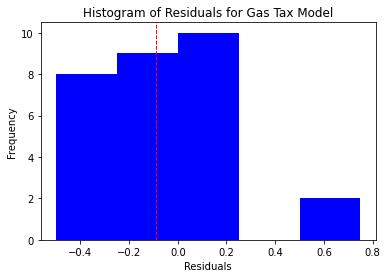

In [34]:
pred = rs.predict(X_test)
pred_df = (
    pd.DataFrame(pred, columns=["prediction"], index=X_test.index)
    .join(X_test)
    .join(y_test)
)
pred_df["resid"] = pred_df.gas_tax_imp - pred_df.prediction
plt.hist(pred_df.resid, color="blue", bins=np.arange(-0.5, 1.0, 0.25))
plt.axvline(pred_df.resid.mean(), color="red", linestyle="dashed", linewidth=1)
plt.title("Histogram of Residuals for Gas Tax Model")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.xlim()

Text(0, 0.5, 'Residuals')

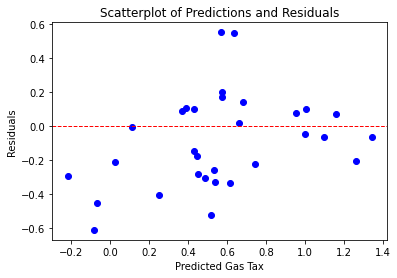

In [36]:
plt.scatter(pred_df.prediction, pred_df.resid, color="blue")
plt.axhline(0, color="red", linestyle="dashed", linewidth=1)
plt.title("Scatterplot of Predictions and Residuals")
plt.xlabel("Predicted Gas Tax")
plt.ylabel("Residuals")

^ These residuals are problematic. We are always overpredicting (predicted values are higher than actual values) at the lower range and upper range of the predicted values. This is not what we want and is perhaps warning us of an unaccounted-for nonlinear relationship.

### Summary

When our data is linearly separable, linear SVR can be an efficient choice. However, when linear separability is not possible, we should explore nonlinear models.